In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cplex 
#import ot
from make_ellipse import *
import math
import numpy.linalg as nla
from time import time
from keras.datasets import mnist
import cupy as cp 
import cupy.linalg as cla
from MDrot import *
from prepare_data import*
from sinkhorn import sinkhorn_gpu
from sinkhorn import sinkhorn_with_rounding
#from numba import cuda 


In [7]:

def cplex_solve(C,p,q,s):
    m,n,k=C.shape

    # Create a CPLEX problem
    problem = cplex.Cplex()
    problem.objective.set_sense(problem.objective.sense.minimize)



    #define variable
    variables=[f'{i},{j},{l}' for i in range(m) for j in range(n) for l in range(k)]
    problem.variables.add(names=variables, types=["C"] * len(variables), lb=[0.0] * len(variables))


    #set objective function
    obj_coef=C.reshape(-1).tolist()
    problem.objective.set_linear(list(zip(variables,obj_coef)))

    #define constraints
    constraints=[]
    for i in range(m):
        constraints+=[[[f'{i},{j},{l}' for j in range(n) for l in range(k)],[1]*(n*k)]]

    for j in range(n):
        constraints+=[[[f'{i},{j},{l}' for i in range(m) for l in range(k)],[1]*(m*k)]]

    for l in range(k):
        constraints+=[[[f'{i},{j},{l}' for i in range(m) for j in range(n)],[1]*(m*n)]]


    senses=["E"]*(m+n+k)
    rhs=[p[i] for i in range(m)]+[q[j] for j in range(n)]+[s[l] for l in range(k)]
    problem.linear_constraints.add(lin_expr=constraints,
                                senses=senses,
                                rhs=rhs           
    )

    #solve
    problem.solve()


    # Get the solution
    solution = problem.solution
    Obj=solution.get_objective_value()
    Opt=np.zeros(len(variables),dtype='float64')
    length=len(variables)
    for i in range(len(variables)):
        Opt[i]=solution.get_values(variables[i])
    #    if i%100000==0:
    #        print(i/length)
    # Print the results
    #print("Solution status:", solution.get_status())
    #print("Objective value:", solution.get_objective_value())

    return {'Opt':Opt,
            'Obj':Obj} 

In [2]:
# thí nghiệm

def experiment1(N,DR_maxiters=1000,DR_step=1e-6,Sk_maxiters=1000,Sk_step=1,seed=20,**kwargs):
    size=kwargs.pop('size',60)
    is_grd_truth_prepared=kwargs.pop('is_grd_truth_prepared',False)
    #data parameter
    sample_number = 3*N
    width = size
    ellipses = make_nested_ellipses(width, sample_number, seed=seed)

    Obj_mean=np.zeros(DR_maxiters)
    
    #experiments
    for j in range(N):
        #data generate
        n=3        
        supports_list=list()
        for i in range(3*j,3*j+3):
            supports_list.append(convert_support(ellipses[i]))
        weight=list(np.ones(n)/n)
        support=compute_support(supports_list,weight)
        mass=list()
        for i in range(3*j,3*j+3):
            mass.append(convert_mass(ellipses[i])/convert_mass(ellipses[i]).sum())
        p,q,s=mass
        p_s,q_s,s_s=supports_list
        C=cost_tensor(p_s,q_s,s_s)

        #cplex ground truth
        if is_grd_truth_prepared:
            filename='data/'+f'size{size}/'+f'seed{seed}/'+f'exp_number{j}'+'.npy'
            Opt=np.fromfile(filename,dtype='float64')
            Obj=(C.reshape(-1)*Opt).sum()
            solution={'Opt':Opt,'Obj':Obj}
        else:
            solution=cplex_solve(C,p,q,s)
        
                
        #DR computing
        x0 = np.tensordot(p,np.tensordot(q,s,0),0)
        #x0=np.zeros(C.shape)
        DR=Mdrot_gpu(x0, C, p, q, s,solution['Opt'], max_iters=DR_maxiters, step=DR_step, compute_r_primal=True, eps_abs=1e-20, verbose=False, print_every=100)
        if j==0:
            DR_Obj={'max':abs(DR['Obj']-solution['Obj']),'mean':abs(DR['Obj']-solution['Obj'])/N,'min':abs(DR['Obj']-solution['Obj'])}
            DR_distance={'max':DR['distance'],'mean':DR['distance']/N,'min':DR['distance']}
        else:
            DR_Obj['max']=np.maximum(DR_Obj['max'],abs(DR['Obj']-solution['Obj']))
            DR_Obj['mean']+=(abs(DR['Obj']-solution['Obj'])/N)
            DR_Obj['min']=np.minimum(abs(DR['Obj']-solution['Obj']),DR_Obj['min'])
            DR_distance['max']=np.maximum(DR_distance['max'],DR['distance'])
            DR_distance['mean']+=(DR['distance']/N)
            DR_distance['min']=np.minimum(DR['distance'],DR_Obj['min'])
        for idx in range(DR_maxiters):
            sub_arr=DR['Obj'][idx:DR_maxiters]
            Obj_mean[idx]+=abs(solution['Obj']-np.sum(sub_arr)/len(sub_arr))
        
        #Sk computing
        SK=sinkhorn_gpu(C,p,q,s,OptSol=solution['Opt'],eta=Sk_step,eps=1e-15,max_iters=Sk_maxiters)
        if j==0:
            SK_Obj={'max':abs(SK['Obj']-solution['Obj']),'mean':abs(SK['Obj']-solution['Obj'])/N,'min':abs(SK['Obj']-solution['Obj'])}
            SK_distance={'max':SK['distance'],'mean':SK['distance']/N,'min':SK['distance']}
        else:
            SK_Obj['max']=np.maximum(SK_Obj['max'],abs(SK['Obj']-solution['Obj']))
            SK_Obj['mean']+=(abs(SK['Obj']-solution['Obj'])/N)
            SK_Obj['min']=np.minimum(abs(SK['Obj']-solution['Obj']),SK_Obj['min'])
            SK_distance['max']=np.maximum(SK_distance['max'],SK['distance'])
            SK_distance['mean']+=(SK['distance']/N)
            SK_distance['min']=np.minimum(SK['distance'],SK_Obj['min'])
        
        
        #compete rario
        ratio_Obj=abs(DR['Obj']-solution['Obj'])/abs(SK['Obj']-solution['Obj'])
        ratio_distance=DR['distance']/SK['distance']
        if j==0:
            Obj_ratio={'max':ratio_Obj,
                        'mean':ratio_Obj/N,
                        'min':ratio_Obj}
            distance_ratio={'max':ratio_distance,'mean':ratio_distance/N,'min':ratio_distance}
        else:
            Obj_ratio['max']=np.maximum(Obj_ratio['max'],ratio_Obj)
            Obj_ratio['mean']+=(ratio_Obj/N)
            Obj_ratio['min']=np.minimum(ratio_Obj,Obj_ratio['min'])
            distance_ratio['max']=np.maximum(distance_ratio['max'],ratio_distance)
            distance_ratio['mean']+=(ratio_distance/N)
            distance_ratio['min']=np.minimum(distance_ratio['min'],ratio_distance)
        
        # print(ratio_Obj)
        # print(Obj_ratio['mean'])
                          
    return {'DR_Obj':DR_Obj,
            'DR_Obj_mean':Obj_mean,
            'DR_distance':DR_distance,
            'SK_distance':SK_distance,
            'SK_Obj':SK_Obj,
            'Obj_ratio':Obj_ratio,
            'distance_ratio':distance_ratio}

def experiment2(N,DR_maxiters=1000,DR_step=1e-6,Sk_maxiters=1000,Sk_step=1,**kwargs):
    
    is_grd_truth_prepared=kwargs.pop('is_grd_truth_prepared',False)
 
    Obj_mean=np.zeros(DR_maxiters)
    
    #load data
    (X,Y), (Xt,Yt) = mnist.load_data()
    img=list()
    for i,j in enumerate(X):
        if Y[i]==0:
            img.append(X[i])

    #experiments
    for j in range(N):
        #data generate

        n=3
        supports_list=list()
        for i in range(j*3,j*3+3):
            supports_list.append(convert_support(img[i]))
        weight=list(np.ones(n)/n)
        support=compute_support(supports_list,weight)
        mass=list()
        for i in range(j*3,j*3+3):
            mass.append(convert_mass(img[i])/convert_mass(img[i]).sum())
        p,q,s=mass
        p_s,q_s,s_s=supports_list
        C=cost_tensor(p_s,q_s,s_s)


        #cplex ground truth
        if is_grd_truth_prepared:
            filename='data/'+'mnist/'+f'exp_number{j}'+'.npy'
            Opt=np.fromfile(filename,dtype='float64')
            Obj=(C.reshape(-1)*Opt).sum()
            solution={'Opt':Opt,'Obj':Obj}
        else:
            solution=cplex_solve(C,p,q,s)
        
                
        #DR computing
        x0 = np.tensordot(p,np.tensordot(q,s,0),0)
        #x0=np.zeros(C.shape)
        DR=Mdrot_gpu(x0, C, p, q, s,solution['Opt'], max_iters=DR_maxiters, step=DR_step, compute_r_primal=True, eps_abs=1e-20, verbose=False, print_every=100)
        if j==0:
            DR_Obj={'max':abs(DR['Obj']-solution['Obj']),'mean':abs(DR['Obj']-solution['Obj'])/N,'min':abs(DR['Obj']-solution['Obj'])}
            DR_distance={'max':DR['distance'],'mean':DR['distance']/N,'min':DR['distance']}
        else:
            DR_Obj['max']=np.maximum(DR_Obj['max'],abs(DR['Obj']-solution['Obj']))
            DR_Obj['mean']+=(abs(DR['Obj']-solution['Obj'])/N)
            DR_Obj['min']=np.minimum(abs(DR['Obj']-solution['Obj']),DR_Obj['min'])
            DR_distance['max']=np.maximum(DR_distance['max'],DR['distance'])
            DR_distance['mean']+=(DR['distance']/N)
            DR_distance['min']=np.minimum(DR['distance'],DR_Obj['min'])
        for idx in range(DR_maxiters):
            sub_arr=DR['Obj'][idx:DR_maxiters]
            Obj_mean[idx]+=abs(solution['Obj']-np.sum(sub_arr)/len(sub_arr))
        
        #Sk computing
        SK=sinkhorn_gpu(C,p,q,s,OptSol=solution['Opt'],eta=Sk_step,eps=1e-15,max_iters=Sk_maxiters)
        if j==0:
            SK_Obj={'max':abs(SK['Obj']-solution['Obj']),'mean':abs(SK['Obj']-solution['Obj'])/N,'min':abs(SK['Obj']-solution['Obj'])}
            SK_distance={'max':SK['distance'],'mean':SK['distance']/N,'min':SK['distance']}
        else:
            SK_Obj['max']=np.maximum(SK_Obj['max'],abs(SK['Obj']-solution['Obj']))
            SK_Obj['mean']+=(abs(SK['Obj']-solution['Obj'])/N)
            SK_Obj['min']=np.minimum(abs(SK['Obj']-solution['Obj']),SK_Obj['min'])
            SK_distance['max']=np.maximum(SK_distance['max'],SK['distance'])
            SK_distance['mean']+=(SK['distance']/N)
            SK_distance['min']=np.minimum(SK['distance'],SK_Obj['min'])
        
        
        #compete rario
        ratio_Obj=abs(DR['Obj']-solution['Obj'])/abs(SK['Obj']-solution['Obj'])
        ratio_distance=DR['distance']/SK['distance']
        if j==0:
            Obj_ratio={'max':ratio_Obj,
                        'mean':ratio_Obj/N,
                        'min':ratio_Obj}
            distance_ratio={'max':ratio_distance,'mean':ratio_distance/N,'min':ratio_distance}
        else:
            Obj_ratio['max']=np.maximum(Obj_ratio['max'],ratio_Obj)
            Obj_ratio['mean']+=(ratio_Obj/N)
            Obj_ratio['min']=np.minimum(ratio_Obj,Obj_ratio['min'])
            distance_ratio['max']=np.maximum(distance_ratio['max'],ratio_distance)
            distance_ratio['mean']+=(ratio_distance/N)
            distance_ratio['min']=np.minimum(distance_ratio['min'],ratio_distance)
        
        # print(ratio_Obj)
        # print(Obj_ratio['mean'])
                          
    return {'DR_Obj':DR_Obj,    #objective function của DR
            'DR_Obj_mean':Obj_mean,
            'DR_distance':DR_distance,  #Distance của DR
            'SK_distance':SK_distance,  #Distance của SK
            'SK_Obj':SK_Obj,       #OF của SK
            'Obj_ratio':Obj_ratio,    #tỉ lệ sai số của DR/SK  
            'distance_ratio':distance_ratio # tỉ lệ khoảng cách Dr/Sk
            }


def prepare_grd_thuth(N,size,seed=20):
    #data parameter

    sample_number = 3*N
    width = size
    ellipses = make_nested_ellipses(width, sample_number, seed=seed)
    for j in range(N):
        #data generate
        n=3        
        supports_list=list()
        for i in range(3*j,3*j+3):
            supports_list.append(convert_support(ellipses[i]))
        weight=list(np.ones(n)/n)
        support=compute_support(supports_list,weight)
        mass=list()
        for i in range(3*j,3*j+3):
            mass.append(convert_mass(ellipses[i])/convert_mass(ellipses[i]).sum())
        p,q,s=mass
        p_s,q_s,s_s=supports_list
        C=cost_tensor(p_s,q_s,s_s)

        #cplex ground truth
        solution=cplex_solve(C,p,q,s)
        filename='data/'+f'size{size}/'+f'seed{seed}/'+f'exp_number{j}'+'.npy'
        solution['Opt'].tofile(filename)
        
def prepare_grd_thuth_2(N):
    #data parameter

    (X,Y), (Xt,Yt) = mnist.load_data()
    img=list()
    for i,j in enumerate(X):
        if Y[i]==0:
            img.append(X[i])
    for j in range(N):
        #data generate

        n=3
        supports_list=list()
        for i in range(j*3,j*3+3):
            supports_list.append(convert_support(img[i]))
        weight=list(np.ones(n)/n)
        support=compute_support(supports_list,weight)
        mass=list()
        for i in range(j*3,j*3+3):
            mass.append(convert_mass(img[i])/convert_mass(img[i]).sum())
        p,q,s=mass
        p_s,q_s,s_s=supports_list
        C=cost_tensor(p_s,q_s,s_s)


        #cplex ground truth
        solution=cplex_solve(C,p,q,s)
        filename='data/'+'mnist/'+f'exp_number{j}'+'.npy'
        solution['Opt'].tofile(filename)
        

In [5]:
# chuẩn bị ground truth, không chạy
prepare_grd_thuth(N=20,size=50,seed=45)

c:\Users\USER\anaconda3\envs\newenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Reduced MIP has 469 rows, 3722627 columns, and 11167881 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 6.73 sec. (3925.60 ticks)
Tried aggregator 1 time.
Detecting symmetries...


In [3]:
DR_maxiters=10
DR_step=1e-6  # khoảng từ 1e-4 đến 1e-8
Sk_maxiters=10
Sk_step=0.1 # 1-0.01
seed=45
size=50
exp=experiment1(10,DR_maxiters=DR_maxiters,DR_step=DR_step,Sk_maxiters=Sk_maxiters,Sk_step=Sk_step,seed=20,size=size,is_grd_truth_prepared=True)

c:\Users\USER\anaconda3\envs\newenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9
Drot terminated at iteration  9


In [ ]:
for i in exp:
    if i=='DR_Obj_mean':
        filename='output/'+'size540/'+'1e-5,1/'+i+'.npy'
        exp[i].tofile(filename)
    else:
        for j in exp[i]:
            filename='output/'+'size50/'+'1e-5,1/'+i+j+'.npy'
            exp[i][j].tofile(filename)

In [3]:
import os
def output():
    exp_list={}
    for i in [0.1,0.5,1]:
        exp_list[i]={}

        folder_path = 'output/'+'size60/'+f'1e-6,{i}'

        # Iterate through all files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                exp_list[i][filename]=np.fromfile(file_path,dtype='float64')
                #print(exp_list[filename])
    return exp_list
exp_list=output()

<function matplotlib.pyplot.show(close=None, block=None)>

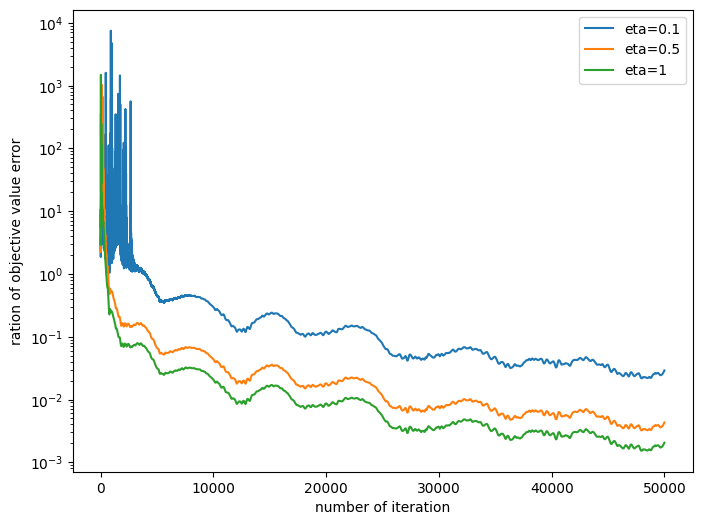

In [4]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['Obj_ratiomean.npy'][1:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
plt.ylabel('ration of objective value error')
plt.xlabel('number of iteration')
plt.legend()
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

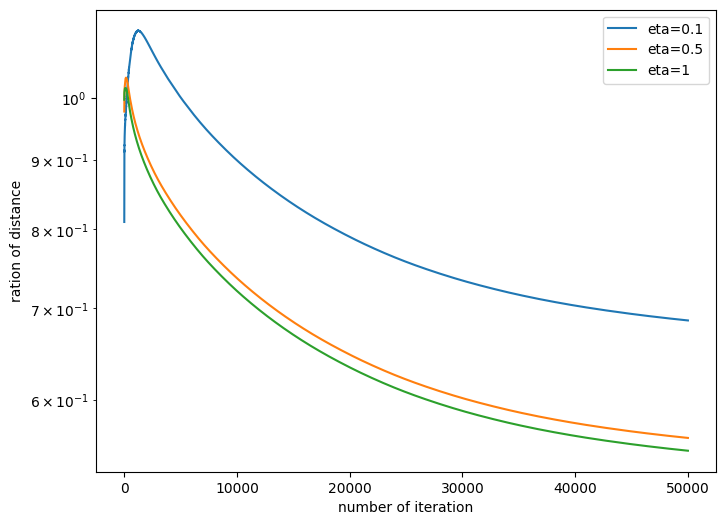

In [5]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['distance_ratiomean.npy'][1:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
plt.legend()
plt.xlabel('number of iteration')
plt.ylabel('ration of distance')
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

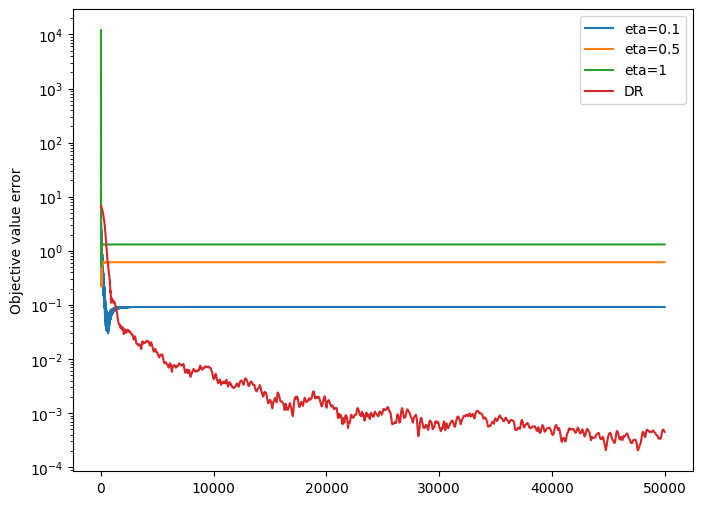

In [42]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['SK_Objmean.npy'][0:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
arr=exp_list[0.1]['DR_Objmean.npy'][0:]
plt.plot(range(len(arr)),arr,label='DR')
plt.ylabel('Objective value error')
plt.legend()
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

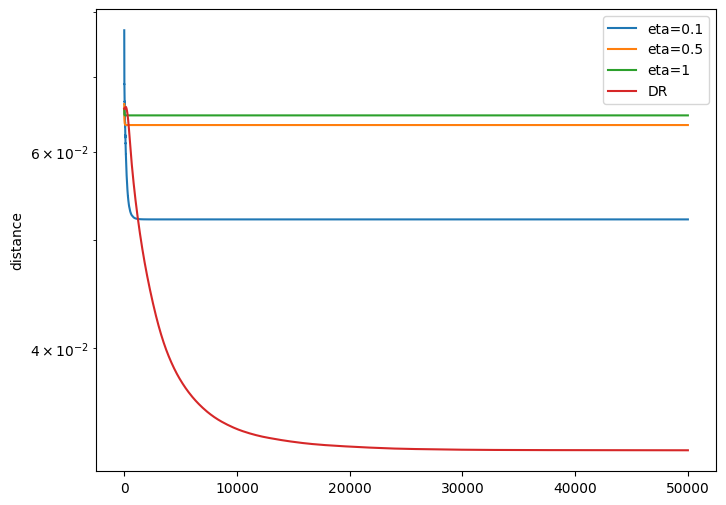

In [15]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['SK_distancemean.npy'][1:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
arr=exp_list[0.1]['DR_distancemean.npy'][1:]
plt.plot(range(len(arr)),arr,label='DR')
plt.ylabel('distance')
plt.legend()
plt.yscale('log')
plt.show

In [ ]:
# Assuming `list` is your dictionary with datasets
for i in exp_list :
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(exp_list[i])),exp_list[i],label=i)
    plt.xlabel("Iteration")
    plt.ylabel("Suboptimality")
    plt.yscale('log')
    plt.legend()
    plt.show()  # Display the current figur




In [ ]:
# Assuming `list` is your dictionary with datasets
for i in exp :
    if i =='DR_Obj_mean':
        continue
    plt.figure(figsize=(8, 6))
    for j in exp[i]:    
        plt.plot(range(len(exp[i][j])), exp[i][j], label=i+j)
    plt.xlabel("Iteration")
    plt.ylabel("Suboptimality")
    plt.yscale('log')
    plt.legend()
    plt.show()  # Display the current figure
plt.figure(figsize=(8, 6))
plt.plot(range(len(exp['DR_Obj_mean'])), exp['DR_Obj_mean']/10, label='mean')
#plt.plot(range(len(a)), a, label='mean')
plt.xlabel("Iteration")
plt.ylabel("Suboptimality")
plt.yscale('log')
plt.legend()
plt.show()  # Display the current figure



In [22]:
seed = 20
n = 3
width = 20
n_features = width ** 2
ellipses = make_nested_ellipses(width, n, seed=seed)

supports_list=list()
for i in range(0,3):
    supports_list.append(convert_support(ellipses[i]))
weight=list(np.ones(n)/n)
support=compute_support(supports_list,weight)
mass=list()
for i in range(n):
    mass.append(convert_mass(ellipses[i])/convert_mass(ellipses[i]).sum())
p,q,s=mass
p_s,q_s,s_s=supports_list
C=cost_tensor(p_s,q_s,s_s)
solution=cplex_solve(C,p,q,s)

c:\Users\USER\anaconda3\envs\newenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 176 rows, 201544 columns, and 604632 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.33 sec. (221.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 176 rows, 201544 columns, and 604632 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.33 sec. (261.63 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.94 sec. (989.98 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0        8.1849        8.1849       20    0.00%
Elapsed time = 1.86 sec. (1619.40 ticks, tree = 0.00 MB, solution

In [ ]:
m,n,k=C.shape
x0 = np.tensordot(p,np.tensordot(q,s,0),0)
#x0=M0['sol']
max_iters = 100000
step = 1e-6
A=Mdrot_gpu(x0, C, p, q, s,solution['Opt'], max_iters=max_iters, step=step, compute_r_primal=True, eps_abs=1e-15, verbose=False, print_every=100)
B= Mdrot_gpu_quadratic_regularizated(x0, C, p, q, s,alpha=250, max_iters=max_iters, step=step, compute_r_primal=True, eps_abs=1e-10, verbose=False, print_every=100)
#M=AARD_inv(x0,C,p,q,s,step,M=1,lamda=0,max_iters=max_iters,eps=1e-2)
#B=AARD(x0,C,p,q,s,1,step,2,max_iters,1e-2)
#M=sinkhorn_gpu(C,p,q,s,eps=1e-5,max_iters=100)

In [ ]:

M0=sinkhorn_gpu(C,p,q,s,OptSol=solution['Opt'],eta=0.5,eps=1e-15,max_iters=50000)
# #M1=sinkhorn_with_rounding(C,p,q,s,0.01,1000)
# #(np.sum(M0['sol']*C),np.sum(M1['sol']*C))

In [ ]:
T=A['sol'].reshape(-1)
x=support[0].reshape(-1)
y=support[1].reshape(-1)
(a,b),mass=support_filter((x,y),T)
plt.scatter(a,b)

In [ ]:
from keras.datasets import mnist
(X,Y), (Xt,Yt) = mnist.load_data()
img=list()
for i,j in enumerate(X):
    if Y[i]==0:
        img.append(X[i])

In [ ]:

# Plot the first three images of the digit 0
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axes[i].imshow(img[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title("Digit 0")
plt.show()


In [ ]:
(X,Y), (Xt,Yt) = mnist.load_data()
img=list()
for i,j in enumerate(X):
    if Y[i]==0:
        img.append(X[i])
n=3
supports_list=list()
for i in range(n):
    supports_list.append(convert_support(img[i]))
weight=list(np.ones(n)/n)
support=compute_support(supports_list,weight)
mass=list()
for i in range(n):
    mass.append(convert_mass(img[i])/convert_mass(img[i]).sum())
p,q,s=mass

p_s,q_s,s_s=supports_list

C=cost_tensor(p_s,q_s,s_s)

solution=cplex_solve(C,p,q,s)

In [ ]:
n=3
weight=list(np.ones(n)/n)
supports_list=[]
mass=[]
for i in range(3,6,1):
    temp1,temp2=convert(img[i])
    supports_list+=[temp1]
    mass+=[temp2]
p,q,s=mass
support=compute_support(supports_list,weight)
p_s,q_s,s_s=supports_list
C=cost_tensor(p_s,q_s,s_s)


In [ ]:
m,n,k=C.shape
x0 = np.tensordot(p,np.tensordot(q,s,0),0)
#x0=M0['sol']
max_iters = 100000
step = 1e-5
M=Mdrot_gpu(x0, C, p, q, s,OptSol=solution['Opt'], max_iters=50000, step=1e-6, compute_r_primal=True,compute_r_dual=True, eps_abs=1e-7, verbose=False, print_every=100)
M0=sinkhorn_gpu(C,p,q,s,OptSol=solution['Opt'],eta=0.1,eps=1e-15,max_iters=50000)

In [ ]:
T=M['sol'].reshape(-1)
x=support[0].reshape(-1)
y=support[1].reshape(-1)
(a,b),mass=support_filter((x,y),T)
plt.scatter(a,b)

In [ ]:
a,b=convert_support(img[0])
plt.scatter(a,b)

In [ ]:
prepare_grd_thuth_2(20)

In [14]:
DR_maxiters=50000
DR_step=1e-6
Sk_maxiters=50000
Sk_step=1
exp=experiment2(10,DR_maxiters=DR_maxiters,DR_step=DR_step,Sk_maxiters=Sk_maxiters,Sk_step=Sk_step,is_grd_truth_prepared=True)

Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999
Drot terminated at iteration  49999


In [ ]:
# Assuming `list` is your dictionary with datasets
for i in exp :
    if i =='DR_Obj_mean':
        continue
    plt.figure(figsize=(10, 6))
    for j in exp[i]:    
        plt.plot(range(len(exp[i][j])), exp[i][j], label=i+j)
    plt.xlabel("Iteration")
    plt.ylabel("Suboptimality")
    plt.yscale('log')
    plt.legend()
    plt.show()  # Display the current figure
plt.figure(figsize=(8, 6))
plt.plot(range(len(exp['DR_Obj_mean'])), exp['DR_Obj_mean']/10, label='mean')
#plt.plot(range(len(a)), a, label='mean')
plt.xlabel("Iteration")
plt.ylabel("Suboptimality")
plt.yscale('log')
plt.legend()
plt.show()  # Display the current figure



In [17]:
for i in exp:
    if i=='DR_Obj_mean':
        filename='output/'+'mnist/'+'1e-6,1/'+i+'.npy'
        exp[i].tofile(filename)
    else:
        for j in exp[i]:
            filename='output/'+'mnist/'+'1e-6,1/'+i+j+'.npy'
            exp[i][j].tofile(filename)

In [ ]:
import os
exp_list={}

folder_path = 'output/'+'mnist/'+'1e-6,0.1'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        exp_list[filename]=np.fromfile(file_path,dtype='float64')
        print(exp_list[filename])


In [7]:
import os
def output():
    exp_list={}
    for i in [0.1,0.5,1]:
        exp_list[i]={}

        folder_path = 'output/'+'mnist/'+f'1e-6,{i}'

        # Iterate through all files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                exp_list[i][filename]=np.fromfile(file_path,dtype='float64')
                #print(exp_list[filename])
    return exp_list
exp_list=output()

<function matplotlib.pyplot.show(close=None, block=None)>

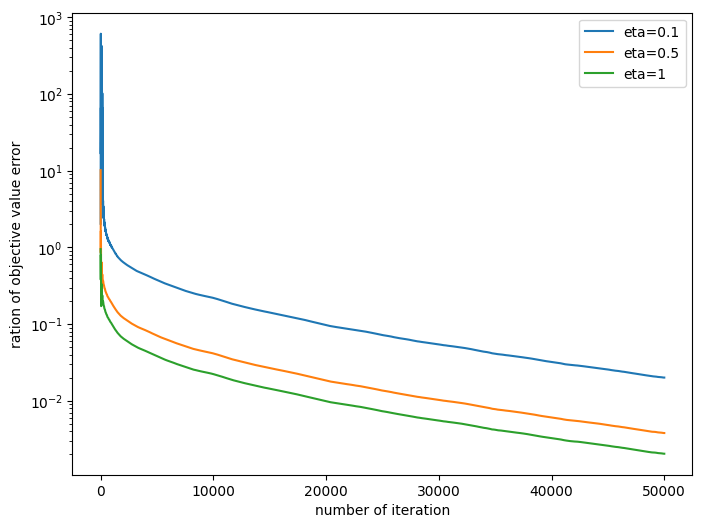

In [8]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['Obj_ratiomean.npy'][1:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
plt.ylabel('ration of objective value error')
plt.xlabel('number of iteration')
plt.legend()
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

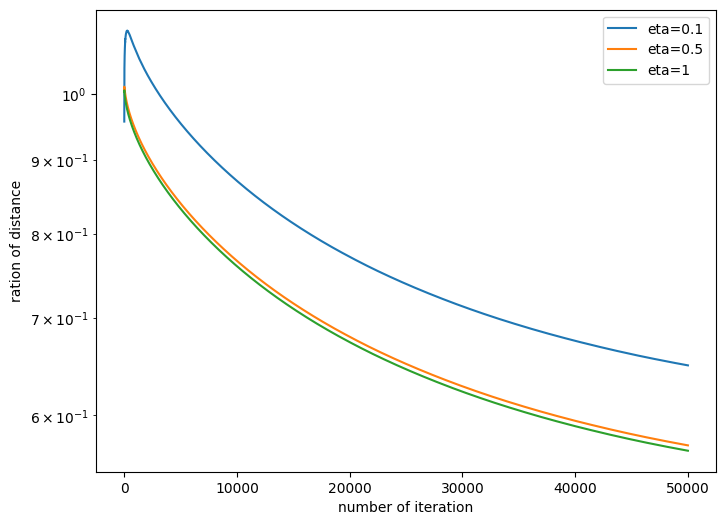

In [9]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['distance_ratiomean.npy'][1:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
plt.legend()
plt.xlabel('number of iteration')
plt.ylabel('ration of distance')
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

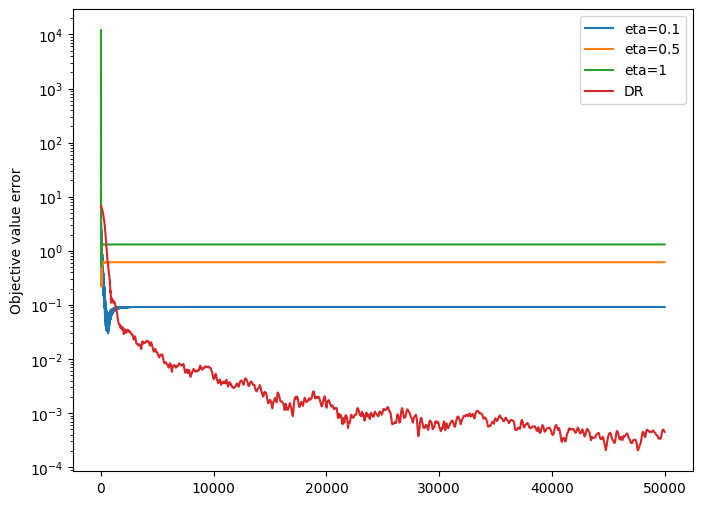

In [13]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['SK_Objmean.npy'][0:]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
arr=exp_list[0.1]['DR_Objmean.npy'][0:]
plt.plot(range(len(arr)),arr,label='DR')
plt.ylabel('Objective value error')
plt.legend()
plt.yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

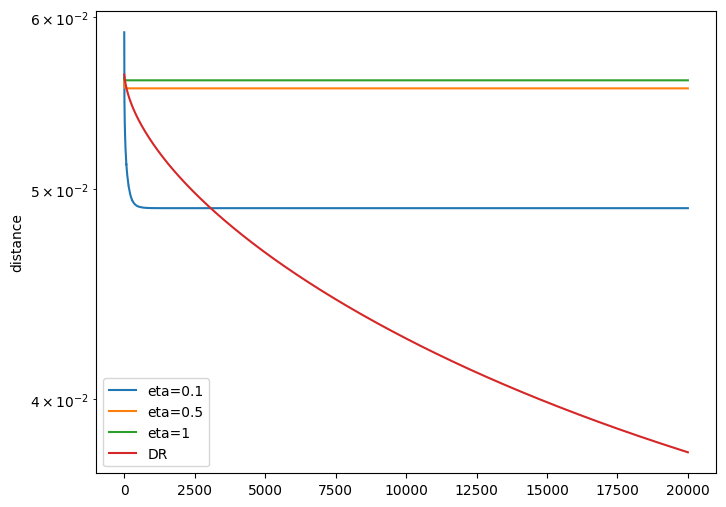

In [11]:
plt.figure(figsize=(8,6))
for i in [0.1,0.5,1]:
    arr=exp_list[i]['SK_distancemean.npy'][1:20000]
    plt.plot(range(len(arr)),arr,label=f'eta={i}')
arr=exp_list[0.1]['DR_distancemean.npy'][1:20000]
plt.plot(range(len(arr)),arr,label='DR')
plt.ylabel('distance')
plt.legend()
plt.yscale('log')
plt.show